# Summative 3
This document is an accompaniment to the main written report, and should only be considered in relation to said report

In [1]:
# First import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor #Random Forest Model
from sklearn.model_selection import GridSearchCV # gridsearch wrapper for hyperparameters
from sklearn.preprocessing import StandardScaler #for scaling
from sklearn.model_selection import train_test_split #for seperating train and test samples
from sklearn.decomposition import PCA #PCA model
from sklearn.metrics import mean_squared_error as MSE #evaluation metric used to construct RMSE
from xgboost import XGBRegressor#XGBoost model

import seaborn as sns #for nice visualisations
from statsmodels.tsa.stattools import adfuller # for stationarity test
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Business use case
The business is a bank, which carries out regular analysis on economic health and potential economic risks. This analysis leads directly to implementing changes to economic policy to minimise these risks. One category of risk, is UK house prices.

•	If house prices rise faster than expected, it could suggest an artificial ‘boom’, with a big ‘bust’ coming later on that would be catastrophic.

•	If future house prices are falling, this suggests measures are needed to stabilise the market.

•	The actual value of estimated average house prices in the future, is a variable which is fed into other economic models

•	For transparency, the business needs to write regular reports for the public showing their estimations, and their planned actions.

For business-specific reasons, the optimal point to know the average house price, which can be represented by a measurement called the House Price Index (HPI), is in the next 3 months. 

As such, the business would like a model which will be able to predict what the HPI will be 3 months in the future.


# The Data
In the following code:

1. I show cuts of the data, and provide simple aggregate summaries, which show the data is clean and well organised.
2. I test and find The UKHPI, and the MACRO, are both order(1) integrated time series’, so I will percentage difference to make them stationary
3. The 3-monthly MACRO needs resampling to match the 1-monthly UKHPI frequency. 
4. They can then be merged together
5. Lastly I show the result

In [2]:
#Read in tables tables
hpi = pd.read_csv("ukhpi.csv")
macro = pd.read_csv("macro.csv")

# View tables
hpi.head(10)
macro.head(10)

#Summary of table shape
print(f'The HPI consists of {hpi.shape[0]} rows')
print(f'The HPI consists of {hpi.shape[1]} columns')

print(f'The MACRO consists of {macro.shape[0]} rows')
print(f'The MACRO consists of {macro.shape[1]} columns')

# Summary of Data types
macro.dtypes
hpi.dtypes

# Total Summary of NA counts
print(f'The hpi consists of {hpi.isna().sum().sum()} NAs')
print(f'The MACRO consists of {macro.isna().sum().sum()} NAs')



,Date,HPI
0,01/01/2002,97623
1,01/02/2002,101164
2,01/03/2002,104705
3,01/04/2002,106121
4,01/05/2002,108852
5,01/06/2002,113304
6,01/07/2002,114214
7,01/08/2002,116743
8,01/09/2002,119576
9,01/10/2002,120486


,date,real.gdp.uk,unemploy.rate.uk,cre.prices.uk,equity.prices.uk,policy.rate.uk,ig.bond.spread.uk,hy.bond.spread.uk,cpi.uk,vix,oil.price
0,01/01/2002,385729,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
1,01/04/2002,387561,5.2,64.905703,65.578826,4.000000,107.593750,859.265625,73.9,21.370938,21.143906
2,01/07/2002,390117,5.2,65.591596,64.264832,4.000000,100.000000,697.153846,74.5,21.600923,25.102923
3,01/10/2002,393074,5.3,66.232832,52.560463,4.000000,125.636364,820.303030,74.6,34.946061,26.885152
4,01/01/2003,396599,5.1,66.611691,50.190128,4.000000,135.545455,884.818182,75.0,30.609848,26.844848
5,01/04/2003,399206,5.2,66.752246,46.449332,3.849206,127.968750,859.812500,75.0,29.973750,31.381250
6,01/07/2003,402985,4.9,67.305230,50.380569,3.750000,108.584615,700.446154,75.5,21.494462,26.113077
7,01/10/2003,407106,5.0,67.935975,53.619476,3.526515,87.257576,601.136364,75.6,19.310758,28.419091
8,01/01/2004,410395,4.9,69.289928,56.079660,3.648438,75.545455,473.954545,76.0,17.397424,29.426364
9,01/04/2004,412641,4.8,70.651411,57.913819,3.903846,78.815385,421.400000,75.9,16.641385,31.997846


The HPI consists of 198 rows
The HPI consists of 2 columns
The MACRO consists of 67 rows
The MACRO consists of 11 columns


date                  object
real.gdp.uk            int64
unemploy.rate.uk     float64
cre.prices.uk        float64
equity.prices.uk     float64
policy.rate.uk       float64
ig.bond.spread.uk    float64
hy.bond.spread.uk    float64
cpi.uk               float64
vix                  float64
oil.price            float64
dtype: object

Date    object
HPI      int64
dtype: object

The hpi consists of 0 NAs
The MACRO consists of 0 NAs


In [3]:
#merge tables
df = hpi.merge(macro, left_on='Date', right_on='date', how = 'left').drop('date', axis=1)
df.head()
#backfill NAs in Macro data
df = df.fillna(method = 'ffill')
df.head()
#convert date to datetime (good practice)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,HPI,real.gdp.uk,unemploy.rate.uk,cre.prices.uk,equity.prices.uk,policy.rate.uk,ig.bond.spread.uk,hy.bond.spread.uk,cpi.uk,vix,oil.price
0,01/01/2002,97623,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
1,01/02/2002,101164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/03/2002,104705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/04/2002,106121,387561.0,5.2,64.905703,65.578826,4.000000,107.593750,859.265625,73.9,21.370938,21.143906
4,01/05/2002,108852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Date,HPI,real.gdp.uk,unemploy.rate.uk,cre.prices.uk,equity.prices.uk,policy.rate.uk,ig.bond.spread.uk,hy.bond.spread.uk,cpi.uk,vix,oil.price
0,01/01/2002,97623,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
1,01/02/2002,101164,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
2,01/03/2002,104705,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
3,01/04/2002,106121,387561.0,5.2,64.905703,65.578826,4.000000,107.593750,859.265625,73.9,21.370938,21.143906
4,01/05/2002,108852,387561.0,5.2,64.905703,65.578826,4.000000,107.593750,859.265625,73.9,21.370938,21.143906


,Date,HPI,real.gdp.uk,unemploy.rate.uk,cre.prices.uk,equity.prices.uk,policy.rate.uk,ig.bond.spread.uk,hy.bond.spread.uk,cpi.uk,vix,oil.price
0,2002-01-01,97623,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
1,2002-01-02,101164,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
2,2002-01-03,104705,385729.0,5.2,64.769197,64.765925,4.230469,122.757576,878.333333,73.9,27.773485,19.365152
3,2002-01-04,106121,387561.0,5.2,64.905703,65.578826,4.000000,107.593750,859.265625,73.9,21.370938,21.143906
4,2002-01-05,108852,387561.0,5.2,64.905703,65.578826,4.000000,107.593750,859.265625,73.9,21.370938,21.143906


In [4]:
#Check stationarity by Testing null hypothesis of order 1 integration
cols = df.iloc[:,1:-1].columns # list of columns to test
adf_result = []
for col in cols:
    adf_result.append(adfuller(df[col], maxlag = 1)[1])

stationarity_df = pd.DataFrame({'variable':cols, 'p_value':adf_result})
stationarity_df

,variable,p_value
0,HPI,0.568132
1,real.gdp.uk,0.918013
2,unemploy.rate.uk,0.940005
3,cre.prices.uk,0.781845
4,equity.prices.uk,0.888911
5,policy.rate.uk,0.813709
6,ig.bond.spread.uk,0.420891
7,hy.bond.spread.uk,0.224785
8,cpi.uk,0.974087
9,vix,0.021681


This shows all values but the vix are order 1 stationary. This makes sense, as the vix is a general measure of market volatility, and I would not expect this to show long term trends. We now percentage difference those columns that require it. I have opted to leave the HPI column in for now, as it will help with running the model in the real world later- it allows much easier generation of an actual HPI value/level, as opposed to just a growth/change number.This also makes for clearer visualisation to stakeholders

In [5]:
#percentage difference to make stationary (pandas pct change)
df[['real.gdp.uk', 'unemploy.rate.uk', 'cre.prices.uk',
       'equity.prices.uk', 'policy.rate.uk', 'ig.bond.spread.uk',
       'hy.bond.spread.uk', 'cpi.uk','oil.price']] = df[['real.gdp.uk', 'unemploy.rate.uk', 'cre.prices.uk',
       'equity.prices.uk', 'policy.rate.uk', 'ig.bond.spread.uk',
       'hy.bond.spread.uk', 'cpi.uk','oil.price']].pct_change()
df['HPI.stationary'] = df['HPI'].pct_change()

#add target variable (next 3 month HPI), and drop observations where this is not possible. 
#The target is fractionally differenced, which makes future visualisation easier but has no other effect on the model
#df['y'] = 100 * ((df['HPI'].shift(-3) - df['HPI'])/df['HPI'])
df['y'] = df['HPI'].shift(-3)/df['HPI']
df = df.dropna()
df.tail()

,Date,HPI,real.gdp.uk,unemploy.rate.uk,cre.prices.uk,equity.prices.uk,policy.rate.uk,ig.bond.spread.uk,hy.bond.spread.uk,cpi.uk,vix,oil.price,HPI.stationary,y
190,2017-01-11,224453,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.936000,0.000000,-0.002839,1.003021
191,2017-01-12,225330,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.936000,0.000000,0.003907,0.993086
192,2018-01-01,224544,0.004306,0.023256,0.018001,0.01583,0.646154,-0.030845,-0.050879,0.008679,10.295077,0.187452,-0.003488,1.006083
193,2018-01-02,225131,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.295077,0.000000,0.002614,1.007564
194,2018-01-03,223772,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.295077,0.000000,-0.006036,1.020481


<AxesSubplot: >

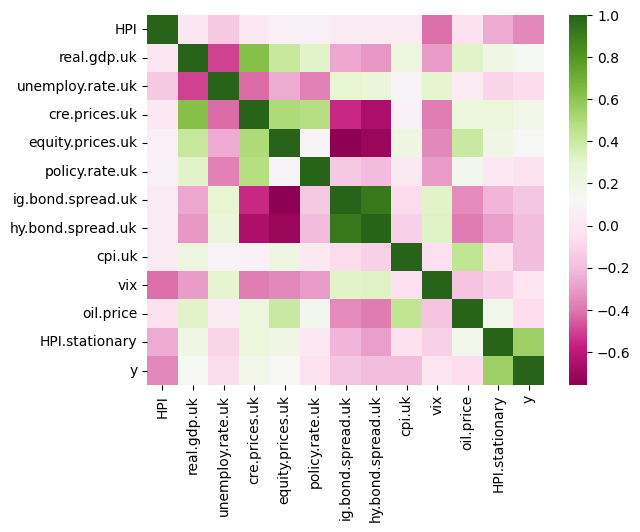

In [6]:
# Show heatmap of correlation between variables
sns.heatmap(df.corr(), cmap = 'PiYG')

# Feature engineering 
As per the reasoning in the attached writen report, I engineer lags of up to 6 data points, and also produce moving averages for up to 6 periods/time-steps

In [7]:
#add lags
from statsmodels.tsa.tsatools import lagmat
temp_df0 = df.drop(['Date', 'HPI', 'y'], axis=1)
temp_df = lagmat(temp_df0, maxlag=6, use_pandas=True)

df = pd.concat([df, temp_df], axis = 1)
df.head(10)

,Date,HPI,real.gdp.uk,unemploy.rate.uk,cre.prices.uk,equity.prices.uk,policy.rate.uk,ig.bond.spread.uk,hy.bond.spread.uk,cpi.uk,...,unemploy.rate.uk.L.6,cre.prices.uk.L.6,equity.prices.uk.L.6,policy.rate.uk.L.6,ig.bond.spread.uk.L.6,hy.bond.spread.uk.L.6,cpi.uk.L.6,vix.L.6,oil.price.L.6,HPI.stationary.L.6
1,2002-01-02,101164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,2002-01-03,104705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,2002-01-04,106121,0.004749,0.000000,0.002108,0.012551,-0.054478,-0.123527,-0.021709,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,2002-01-05,108852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
5,2002-01-06,113304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,2002-01-07,114214,0.006595,0.000000,0.010568,-0.020037,0.000000,-0.070578,-0.188663,0.008119,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,2002-01-08,116743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,27.773485,0.000000,0.036272
8,2002-01-09,119576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,27.773485,0.000000,0.035003
9,2002-01-10,120486,0.007580,0.019231,0.009776,-0.182127,0.000000,0.256364,0.176646,0.001342,...,0.0,0.002108,0.012551,-0.054478,-0.123527,-0.021709,0.0,21.370938,0.091853,0.013524
10,2002-01-11,121700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,21.370938,0.000000,0.025735


In [8]:
#add moving averages
for col in temp_df0.columns:
    for n in range(2,7):
        temp_df0[f'{col}.MA.{n}'] = temp_df0[col].rolling(n).mean()
    temp_df0 = temp_df0.drop([col], axis = 1)
temp_df0.tail(10)

,real.gdp.uk.MA.2,real.gdp.uk.MA.3,real.gdp.uk.MA.4,real.gdp.uk.MA.5,real.gdp.uk.MA.6,unemploy.rate.uk.MA.2,unemploy.rate.uk.MA.3,unemploy.rate.uk.MA.4,unemploy.rate.uk.MA.5,unemploy.rate.uk.MA.6,...,oil.price.MA.2,oil.price.MA.3,oil.price.MA.4,oil.price.MA.5,oil.price.MA.6,HPI.stationary.MA.2,HPI.stationary.MA.3,HPI.stationary.MA.4,HPI.stationary.MA.5,HPI.stationary.MA.6
185,0.000000,0.001571,0.001178,0.000943,0.001976,0.000000,-0.007092,-0.005319,-0.004255,-0.007018,...,0.000000,0.026351,0.019763,0.015811,0.028693,0.007272,0.010123,0.007058,0.006068,0.004858
186,0.001780,0.001187,0.002068,0.001655,0.001379,-0.021739,-0.014493,-0.016189,-0.012951,-0.010792,...,-0.035556,-0.023704,0.001985,0.001588,0.001323,0.010776,0.009184,0.010844,0.008248,0.007225
187,0.001780,0.001187,0.000890,0.001655,0.001379,-0.021739,-0.014493,-0.010870,-0.012951,-0.010792,...,-0.035556,-0.023704,-0.017778,0.001588,0.001323,0.008772,0.008696,0.008022,0.009582,0.007629
188,0.000000,0.001187,0.000890,0.000712,0.001379,0.000000,-0.014493,-0.010870,-0.008696,-0.010792,...,0.000000,-0.023704,-0.017778,-0.014222,0.001323,0.000400,0.004603,0.005588,0.005671,0.007363
189,0.002573,0.001715,0.002176,0.001741,0.001451,-0.011364,-0.007576,-0.016551,-0.013241,-0.011034,...,0.015236,0.010157,-0.010160,-0.008128,-0.006773,-0.001429,0.000559,0.003671,0.004646,0.004872
190,0.002573,0.001715,0.001286,0.001741,0.001451,-0.011364,-0.007576,-0.005682,-0.013241,-0.011034,...,0.015236,0.010157,0.007618,-0.008128,-0.006773,-0.000981,-0.001899,-0.000291,0.002369,0.003398
191,0.000000,0.001715,0.001286,0.001029,0.001451,0.000000,-0.007576,-0.005682,-0.004545,-0.011034,...,0.000000,0.010157,0.007618,0.006094,-0.006773,0.000534,0.000648,-0.000448,0.000549,0.002626
192,0.002153,0.001435,0.002363,0.001890,0.001575,0.011628,0.007752,0.000132,0.000106,0.000088,...,0.093726,0.062484,0.054481,0.043585,0.036321,0.000210,-0.000807,-0.000386,-0.001056,-0.000124
193,0.002153,0.001435,0.001077,0.001890,0.001575,0.011628,0.007752,0.005814,0.000106,0.000088,...,0.093726,0.062484,0.046863,0.043585,0.036321,-0.000437,0.001011,0.000049,0.000214,-0.000444
194,0.000000,0.001435,0.001077,0.000861,0.001575,0.000000,0.007752,0.005814,0.004651,0.000088,...,0.000000,0.062484,0.046863,0.037490,0.036321,-0.001711,-0.002304,-0.000751,-0.001168,-0.000828


<AxesSubplot: >

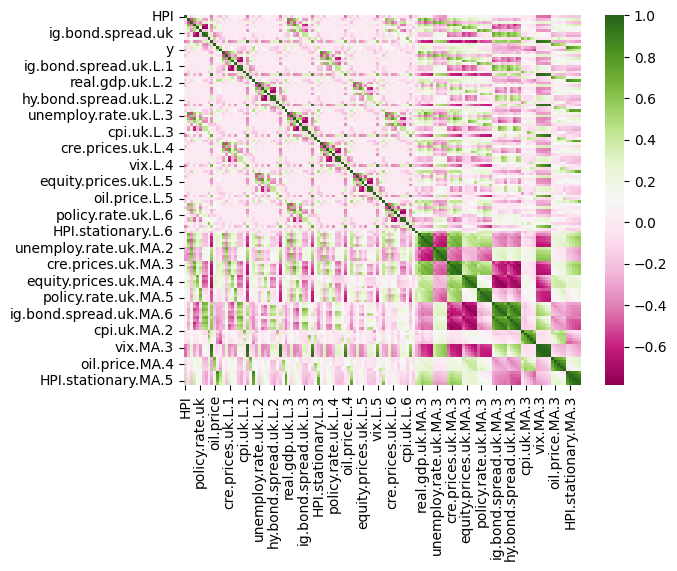

In [9]:
#concat MA values with our main dataframe
df = pd.concat([df, temp_df0], axis = 1)
#drop Nas resulting from the above feature engineering process
df = df.dropna() 
# Show heatmap of correlation between variables, now including newly engineered ones
sns.heatmap(df.corr(), cmap = 'PiYG')

We can now see that we have a large number of variables. Some have strong correlations to the target variable, whilst many have only weak correlations. The data is now a prime candidate for some form of feature reduction. However, this can only be carried out after splitting and scaling

# Split data into training and evaluation sets. 
As per the rationale in the written report, I use a time series split rather than a random shuffle

In [10]:
X = df.drop(['Date', 'HPI', 'y'], axis=1)
y = df['y']
X_cols = X.columns # save column names for later

seed = 7 # for reproduceability
test_size = 0.25 #I've opted for a 75% training sample, and a 25% testing sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle = False)

# Scale the data:
a.	I fit the scaler to X_train data

b.	I use the scaler to transform the X_test data

In [11]:
# initiate scaler and fit to training data
scaler = StandardScaler()
scaler = scaler.fit(X_train)

#save model if applicable
#dump(scaler, 'scaler.joblib')

#apply transforms
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality reduction:
a.	I Fit a PCA model  to the X-train set

b.	I Review the percentage of explained variance and find a suitable cut-off for component number, in this case the number which explains 95% of the variance

c.	For future speed, I rebuild the PCA model to include only the required number of components

d.	Finally, I use the fitted model to transform the X-test set

In [12]:
#The below was used to work out the ideal n_components number.
pca = PCA()
pca.fit(X_train)
evr = pd.Series(pca.explained_variance_ratio_)
evrsum = evr.cumsum()
evrsum.iloc[25:35]

PCA()

25    0.913014
26    0.918647
27    0.923795
28    0.928680
29    0.933425
30    0.937948
31    0.942279
32    0.946412
33    0.950335
34    0.953902
dtype: float64

In [13]:
#based on the above, we will use 33 components, which captures 95% variance
pca = PCA(n_components = 33)
pca.fit(X_train) #fit model

#dump(pca, 'pca.joblib') #save model

#apply transforms
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

PCA(n_components=33)

# Optimise and Fit Regression model. 
a. First I instantiate Random Forest and XGBoost Regressors

b. Next I set up paramater grids, which will be used to optimise the models

c. Lastly, I Grid Search the hyperparameters for both models, and return optimally parameterized models

In [14]:
#Initiate instance of various classifiers, using max CPU cores for speed
XGB = XGBRegressor(n_jobs = -1)
RF = RandomForestRegressor(n_jobs = -1)


#XGBoost
xg_params = [{'max_depth': [5, 10, 15],
         'n_estimators': [50,100,200], 
         'subsample': [0.5,0.7,0.9], 
         'eta': [0.2,0.3]}]

gs_xg = GridSearchCV(XGB,
                      param_grid=xg_params,
                      cv=10)
gs_xg.fit(X_train, y_train)
gs_xg.best_params_
gs_xg.score(X_train, y_train)

#Random Forest
rf_params = [{ 
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8]}]

gs_rf = GridSearchCV(RF,
                      param_grid=rf_params,
                      cv=10)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_
gs_rf.score(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid=[{'eta': [0.2, 0.3], 'max_depth': [5, 10, 15],
                          'n_estimators': [50, 100, 200],
                          'subsample': [0.5, 0.7, 0.9]}])

{'eta': 0.2, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.9}

0.9996703551533263

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_depth': [4, 6, 8],
                          'max_features': ['sqrt', 'log2'],
                          'n_estimators': [100, 200]}])

{'max_depth': 6, 'max_features': 'log2', 'n_estimators': 200}

0.806615318090133

In [16]:
# EXAMPLES from the different regressors, Predicting examples from the test sample when compared to the real target value
test_df = pd.DataFrame(X_test)
test_df['y_actual']= y_test.values
test_df['y_xg_pred'] = gs_xg.predict(test_df.iloc[:, 0:33])
test_df['y_rf_pred'] = gs_rf.predict(test_df.iloc[:, 0:33])
test_df.iloc[0:15,-3:]

,y_actual,y_xg_pred,y_rf_pred
0,1.033656,1.029310,1.020415
1,1.034808,1.042925,1.023202
2,1.027053,1.024211,1.020286
3,1.011312,1.014089,1.013761
4,0.996233,1.030728,1.011673
5,0.997559,1.011095,1.017057
6,0.993797,1.013702,1.013348
7,0.998002,0.985789,1.009404
8,0.999311,0.993616,1.010190
9,1.013427,1.009704,1.010273


# Evaluate the models
Showing error stats, and a plot of the actual HPI against the models' predictions

In [18]:
#A baseline for Our predictions:
print(f"The mean change over 3 months is: {round(100*(test_df['y_actual'].mean() -1),2)}%")

#Model Results
val1 = MSE(test_df['y_actual'], test_df['y_xg_pred'])
print(f"The Root Mean Square Error of the XGBoost Model is: {round(100 * val1**0.5, 2)}")
val2 = MSE(test_df['y_actual'], test_df['y_rf_pred'])
print(f"The Root Mean Square Error of the Random Forest Model is: {round(100 * val2**0.5, 2)}")

The mean change over 3 months is: 1.28%
The Root Mean Square Error of the XGBoost Model is: 1.38
The Root Mean Square Error of the Random Forest Model is: 1.3


<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

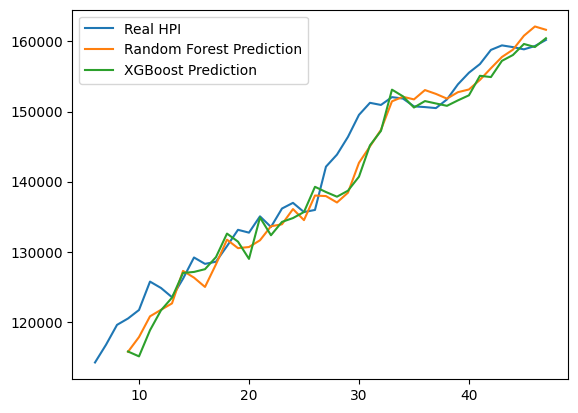

In [19]:
#Convert stationary predictions back into HPI prices, to visualise
test_df['Real_HPI'] = df['HPI']
test_df['XGB_Prediction'] = test_df['Real_HPI'] * test_df['y_xg_pred'] #convert from % change, back to HPI number
test_df['XGB_Prediction'] = test_df['XGB_Prediction'].shift(3) # shift to line up dates: predicted value with actual value
test_df['RF_Prediction'] =  test_df['Real_HPI'] * test_df['y_rf_pred']
test_df['RF_Prediction'] = test_df['RF_Prediction'].shift(3)

#plot
test_df['Real_HPI'].plot(label = 'Real HPI')
test_df['RF_Prediction'].plot(label = 'Random Forest Prediction')
test_df['XGB_Prediction'].plot(label = 'XGBoost Prediction')
plt.legend()
plt.show()

# Conclusions
From the results above, we can see that the 3-month forward predictions of both models are not ideal. Although the models generally synch up with the 3 month HPI prices, as reflected by the low RMSE, if we compare this to the mean percentage variance, we see that, in comparative terms, the error is actually quite high. 


In other words, if we compare our models’ predictions to simply duplicating the previous value, we find, on average, that the models perform worse. The plot shows that this is not actually the full story – the accuracy of the models is quite variable across the test set, with both models performing well at the start and end, and both showing significant deviations from the HPI in the middle.


It appears that something happens during the middle timesteps, which our model is not able to capture – future investigation into this would be beneficial. Further reflections on how these results could be improved in the future, are provided in the accompanying document.


# References
Auterson, Toby, Working paper No.6, Forecasting house prices, Office for Budget Responsibilities. July 2014 

Bergstra , James and Bengio Yoshua, "Random Search for Hyper-Parameter Optimization" (2012) 

Bronselaer, A. (2021). Data Quality Management: An Overview of Methods and Challenges. In: Andreasen, T., De Tré, G., Kacprzyk, J., Legind Larsen, H., Bordogna, G., Zadrożny, S. (eds) Flexible Query Answering Systems. FQAS 2021. Lecture Notes in Computer Science(), vol 12871. Springer, Cham.  

Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16), 785–794. doi: 10.1145/2939672.2939785 

Falkner, Stefan, Klein, Aaron and Hutter, Frank. BOHB: Robust and Efficient Hyperparameter Optimization at Scale (2018)

Gibson, Adam and Patterson, Josh , "Deep Learning: A Practitioner's Approach", "O'Reilly Media, Inc.", Jul 28, 2017

Grinsztajn , Léo (SODA), Oyallon , Edouard (ISIR, CNRS), Varoquaux , Gaël (SODA): Why do tree-based models still outperform deep learning on tabular data? 18 Jul 2022.

Grus Joel, Data Science from Scratch, 2nd Edition, O'Reilly Media, Inc., May 2019.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Springer. (Online version)

Huyen, Chip , Designing Machine Learning Systems: An Iterative Process for Production-Ready Applications – 31 May 2022

Jolliffe IT, Cadima J. Principal component analysis: a review and recent developments. Philos Trans A Math Phys Eng Sci. 2016 Apr 13;374(2065):20150202

Jolliffe, I. T. (2002). Principal Component Analysis. Wiley Interdisciplinary Reviews: Computational Statistics, 2(4), 433–459.

Kelleher John D, Mac Namee Brian , and D'Arcy Aoife , "Applied Machine Learning",2nd edition. — Boston: The MIT Press, 2020 

Kingma, D. P., & Ba, J. (2015). "Adam: A Method for Stochastic Optimization."

McInnes, L., Healy, J., & Melville, J. (2018). "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction." arXiv preprint arXiv:1802.03426

Müller , Andreas C. and Guido, , Sarah. Introduction to Machine Learning with Python, 2019 

Office of National Statistics,  Available at: https://www.ons.gov.uk/aboutus/whatwedo/statistics (Accessed: 24/11/2023)

Serdar CC, Cihan M, Yücel D, Serdar MA. Sample size, power and effect size revisited: simplified and practical approaches in pre-clinical, clinical and laboratory studies. Biochem Med (Zagreb). 2021 Feb 15;31(1):010502. doi: 10.11613/BM.2021.010502. Epub 2020 Dec 15. PMID: 33380887; PMCID: PMC7745163

Shumway , Robert H. and Stoffer , David S. - "Time Series Analysis and Its Applications: With R Examples", 2017

Shumway, Robert H. and Stoffer, David S. "Time Series Analysis and Its Applications: With R Examples" 2017

Turrell, A E, The explosion in time series forecasting packages in data science (2023), Available at: https://aeturrell.com/blog/posts/time-series-explosion/ (Accessed: 24/11/2023)

van der Maaten, L., & Hinton, G. (2008). "Visualizing Data using t-SNE." Journal of Machine Learning Research, 9(Nov), 2579–2605. 

Witten, James, Hastie, T., & Tibshirani, R. (2013). "An Introduction to Statistical Learning."

Yin Haixing , Fan Fan, Zhang Jiazhi , Li Hanyang  and Lau, Ting Fung, The Importance of Domain Knowledge, MLD, CMU, August 31, 2020 

Zaidi, Nayyar, Feature Engineering in Machine Learning, Deakin University, September 2015 
